In [1]:
import codigo
from codigo import utils
from codigo import model_utils

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pickle import dump

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importar Dataset depurado

In [3]:
df_Inicial = pd.read_csv(r'dataset/generado/datasetDepurado.csv')

# Revisamos las columnas que contiene el Dataset

In [4]:
df_Inicial.head()

,ID,Date,Glucose level
0,LIB193263,2020-06-09 19:08:00,99.0
1,LIB193263,2020-06-09 19:23:00,92.0
2,LIB193263,2020-06-09 19:38:00,86.0
3,LIB193263,2020-06-09 19:53:00,85.0
4,LIB193263,2020-06-09 20:08:00,85.0


In [5]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID             object 
 1   Date           object 
 2   Glucose level  float64
dtypes: float64(1), object(2)
memory usage: 67.9+ MB


### Cambiamos el formato de la columna Date de object a datetime64

In [6]:
df_Inicial['Date']=pd.to_datetime(df_Inicial['Date'])

In [7]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID             object        
 1   Date           datetime64[ns]
 2   Glucose level  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.9+ MB


In [8]:
df_Inicial['Date'].min()

Timestamp('2018-01-06 00:31:00')

In [9]:
df_Inicial['Date'].max()

Timestamp('2022-03-20 23:58:00')

# Seleccionar los pacientes para evaluación

In [10]:
dfPacienteCount= pd.DataFrame(df_Inicial.ID.value_counts().sort_values(ascending=False))
dfPacienteCount.columns = ['Freq']
dfPacienteCount

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
...,...
LIB193366,1287
LIB193398,1253
LIB193283,1098
LIB193365,1057


In [11]:
pacientesNoDeseados=['LIB193321']
dfPacienteCount=dfPacienteCount[~dfPacienteCount.index.isin(pacientesNoDeseados)]

In [12]:
dfPacienteCount

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
...,...
LIB193282,1808
LIB193366,1287
LIB193398,1253
LIB193283,1098


<AxesSubplot: >

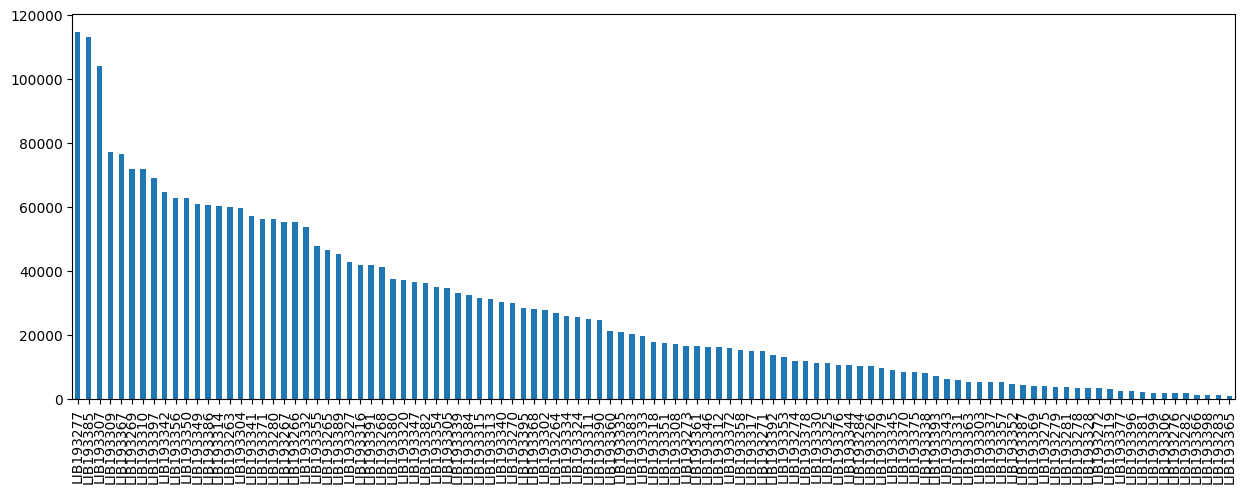

In [13]:
dfPacienteCount['Freq'].plot.bar(figsize=(15, 5))

In [14]:
dfPacienteCount.describe()

,Freq
count,107.000000
mean,27726.009346
std,25694.131765
min,1057.000000
25%,6717.000000
50%,17889.000000
75%,41868.000000
max,114563.000000


In [15]:
train_share = 1
val_share = 0
lag=30
n_ahead=1
formato='%Y-%m-%d %H:%M:%S'
min=15

strMin=str(min)+'min'

In [16]:
features=['Glucose level','hour','min','pod_id','level_id','level_label']
featuresObj=['Glucose level','hour','min','pod_id','level_id']

In [17]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))
scalerHours = load(open('dataset/generado/scalerHours.scaler', 'rb'))
scalerMin = load(open('dataset/generado/scalerMin.scaler', 'rb'))
scalerPodId = load(open('dataset/generado/scalerPodId.scaler', 'rb'))
scalerLevelId = load(open('dataset/generado/scalerLevelId.scaler', 'rb'))

## Pacientes del Q1

In [18]:
dfPacienteCount[dfPacienteCount['Freq'].between(0, 6717)]

,Freq
LIB193343,6323
LIB193331,6026
LIB193363,5362
LIB193303,5283
LIB193337,5187
LIB193357,5169
LIB193352,4775
LIB193387,4490
LIB193369,4170
LIB193275,4095


'LIB193399' tiene 1913 muestras

In [19]:
ID_Paciente=pq1='LIB193399'


diasP1=[]
especialesP1=[]

In [20]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [21]:
dfpaciente

,ID,Date,Glucose level
2964772,LIB193399,2020-09-30 18:15:00,105.0
2964773,LIB193399,2020-09-30 18:30:00,101.0
2964774,LIB193399,2020-09-30 18:45:00,98.0
2964775,LIB193399,2020-09-30 19:00:00,99.0
2964776,LIB193399,2020-09-30 19:15:00,108.0
...,...,...,...
2966680,LIB193399,2020-10-20 20:50:00,83.0
2966681,LIB193399,2020-10-20 21:05:00,76.0
2966682,LIB193399,2020-10-20 21:20:00,67.0
2966683,LIB193399,2020-10-20 21:35:00,63.0


In [22]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [23]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-09-30 18:15:00,105.0,18,15,4,0,euglycemia
2020-09-30 18:30:00,101.0,18,30,4,0,euglycemia
2020-09-30 18:45:00,98.0,18,45,4,0,euglycemia
2020-09-30 19:00:00,99.0,19,0,4,0,euglycemia
2020-09-30 19:15:00,108.0,19,15,4,0,euglycemia
...,...,...,...,...,...,...
2020-10-20 20:45:00,83.0,20,45,4,0,euglycemia
2020-10-20 21:00:00,76.0,21,0,5,0,euglycemia
2020-10-20 21:15:00,67.0,21,15,5,-1,hypoglycemia


In [24]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2020-09-30 18:15:00,0.141304,0.782609,0.254237,0.6,0.5
2020-09-30 18:30:00,0.132609,0.782609,0.508475,0.6,0.5
2020-09-30 18:45:00,0.126087,0.782609,0.762712,0.6,0.5
2020-09-30 19:00:00,0.128261,0.826087,0.000000,0.6,0.5
2020-09-30 19:15:00,0.147826,0.826087,0.254237,0.6,0.5
...,...,...,...,...,...
2020-10-20 20:45:00,0.093478,0.869565,0.762712,0.6,0.5
2020-10-20 21:00:00,0.078261,0.913043,0.000000,0.8,0.5
2020-10-20 21:15:00,0.058696,0.913043,0.254237,0.8,0.0


### Análisis del Paciente 1: ID: LIB193399

<AxesSubplot: ylabel='level_label'>

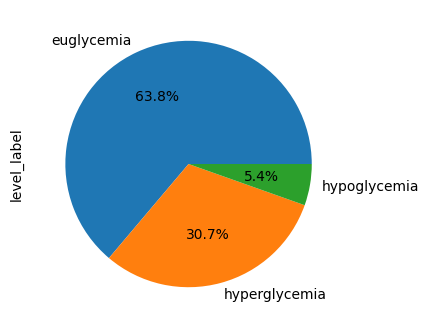

In [25]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-15 20:30:00
Rango Inicio Objetivo: 2020-10-16 04:00:00
Rango Fin Objetivo   : 2020-10-16 23:59:59


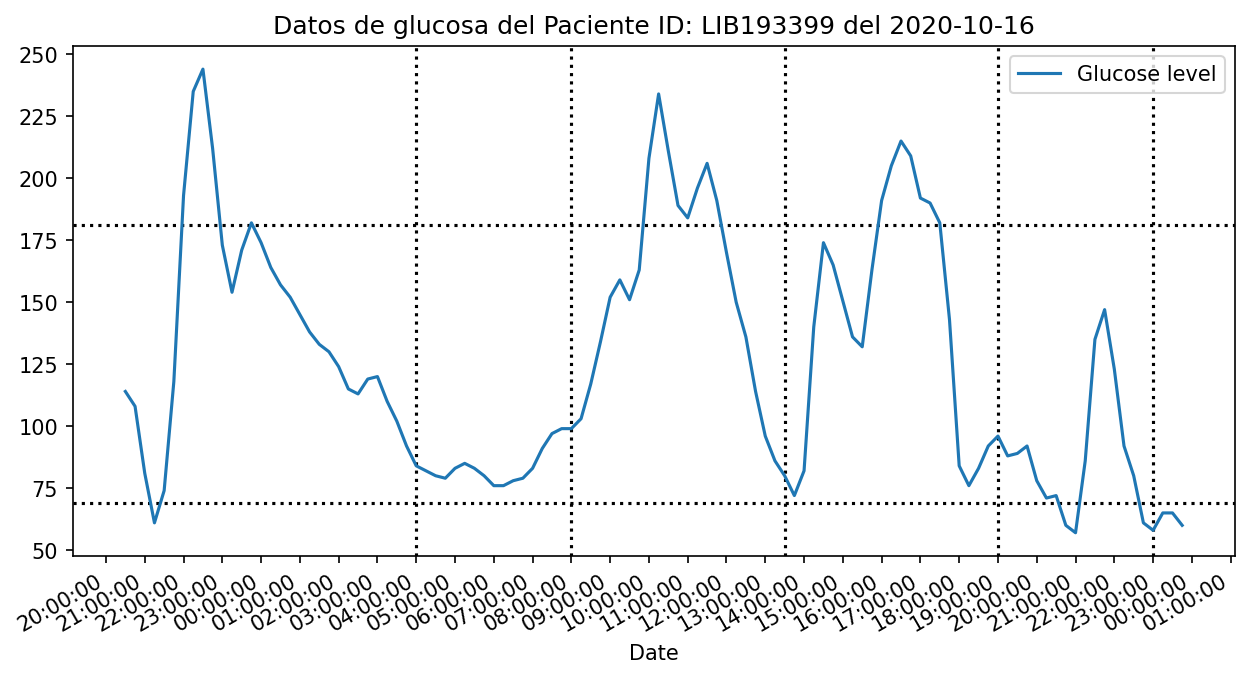

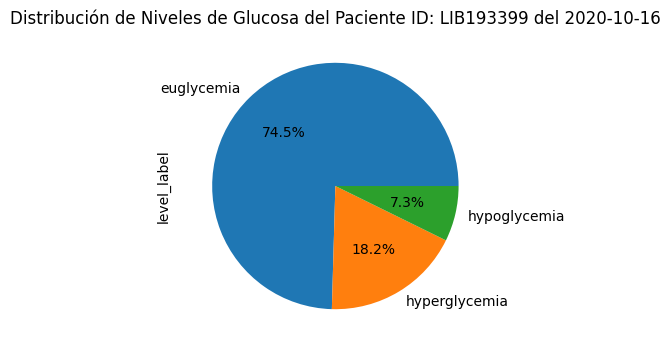

In [26]:
dateObj='2020-10-16'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [27]:
df_rango.loc[dateObj+' 20:00:00':dateObj+' 21:30:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-10-16 20:00:00,78.0,20,0,4,0,euglycemia
2020-10-16 20:15:00,71.0,20,15,4,0,euglycemia
2020-10-16 20:30:00,72.0,20,30,4,0,euglycemia
2020-10-16 20:45:00,60.0,20,45,4,-1,hypoglycemia
2020-10-16 21:00:00,57.0,21,0,5,-1,hypoglycemia
2020-10-16 21:15:00,86.0,21,15,5,0,euglycemia
2020-10-16 21:30:00,135.0,21,30,5,0,euglycemia


In [28]:
especialesP1.append('2020-10-16 20:45:00')

### Selección del Dia 2 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-02 20:30:00
Rango Inicio Objetivo: 2020-10-3 04:00:00
Rango Fin Objetivo   : 2020-10-3 23:59:59


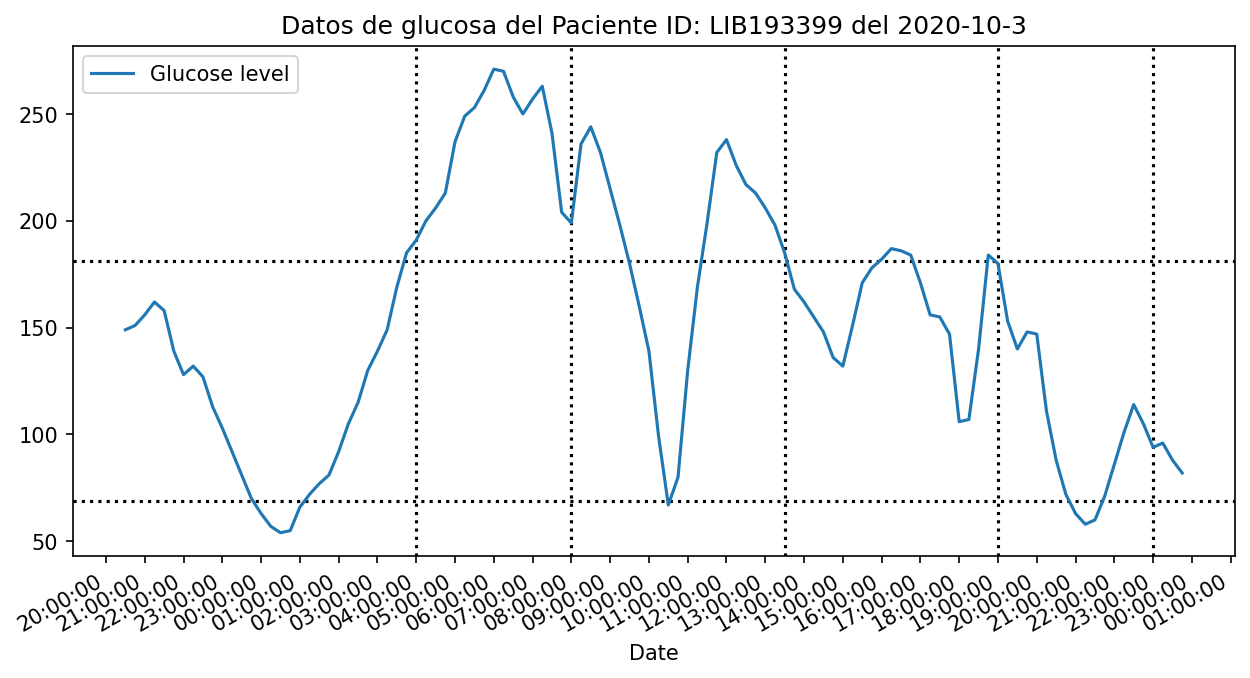

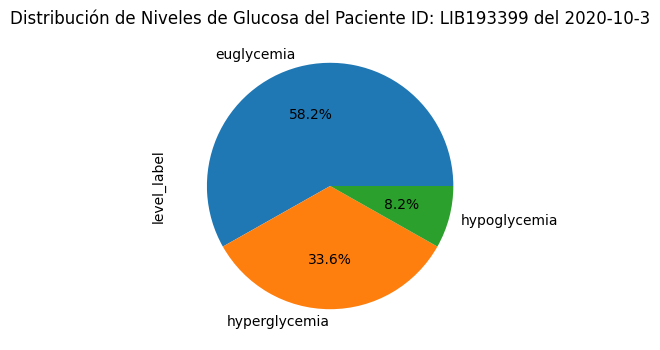

In [29]:
dateObj='2020-10-3'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [30]:
df_rango.loc[dateObj+' 20:00:00':dateObj+' 23:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-10-03 20:00:00,147.0,20,0,4,0,euglycemia
2020-10-03 20:15:00,111.0,20,15,4,0,euglycemia
2020-10-03 20:30:00,88.0,20,30,4,0,euglycemia
2020-10-03 20:45:00,72.0,20,45,4,0,euglycemia
2020-10-03 21:00:00,63.0,21,0,5,-1,hypoglycemia
2020-10-03 21:15:00,58.0,21,15,5,-1,hypoglycemia
2020-10-03 21:30:00,60.0,21,30,5,-1,hypoglycemia
2020-10-03 21:45:00,71.0,21,45,5,0,euglycemia
2020-10-03 22:00:00,86.0,22,0,5,0,euglycemia


In [31]:
especialesP1.append('2020-10-03 21:00:00')

### Selección del Dia 3 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-09 20:30:00
Rango Inicio Objetivo: 2020-10-10 04:00:00
Rango Fin Objetivo   : 2020-10-10 23:59:59


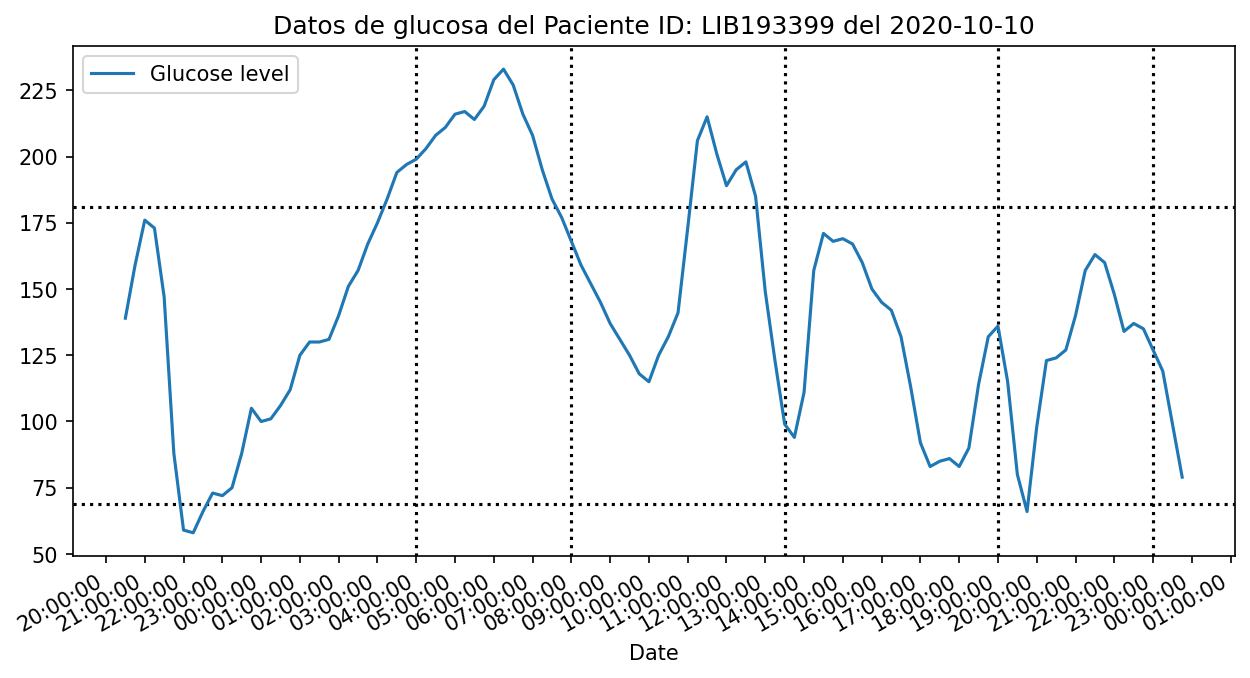

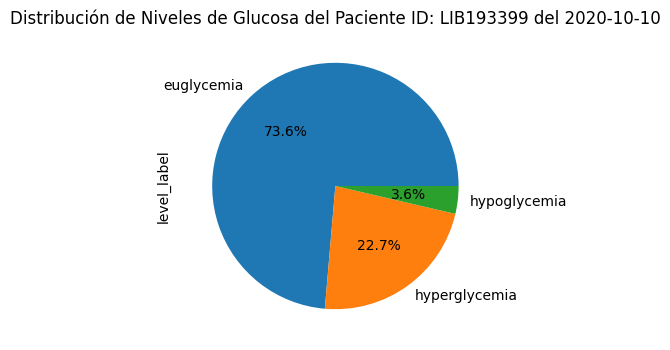

In [32]:
dateObj='2020-10-10'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [33]:
df_rango.loc[dateObj+' 19:00:00':dateObj+' 20:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-10-10 19:00:00,136.0,19,0,4,0,euglycemia
2020-10-10 19:15:00,115.0,19,15,4,0,euglycemia
2020-10-10 19:30:00,80.0,19,30,4,0,euglycemia
2020-10-10 19:45:00,66.0,19,45,4,-1,hypoglycemia
2020-10-10 20:00:00,98.0,20,0,4,0,euglycemia


In [34]:
especialesP1.append('2020-10-10 19:45:00')

### Selección del Dia 4 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-11 20:30:00
Rango Inicio Objetivo: 2020-10-12 04:00:00
Rango Fin Objetivo   : 2020-10-12 23:59:59


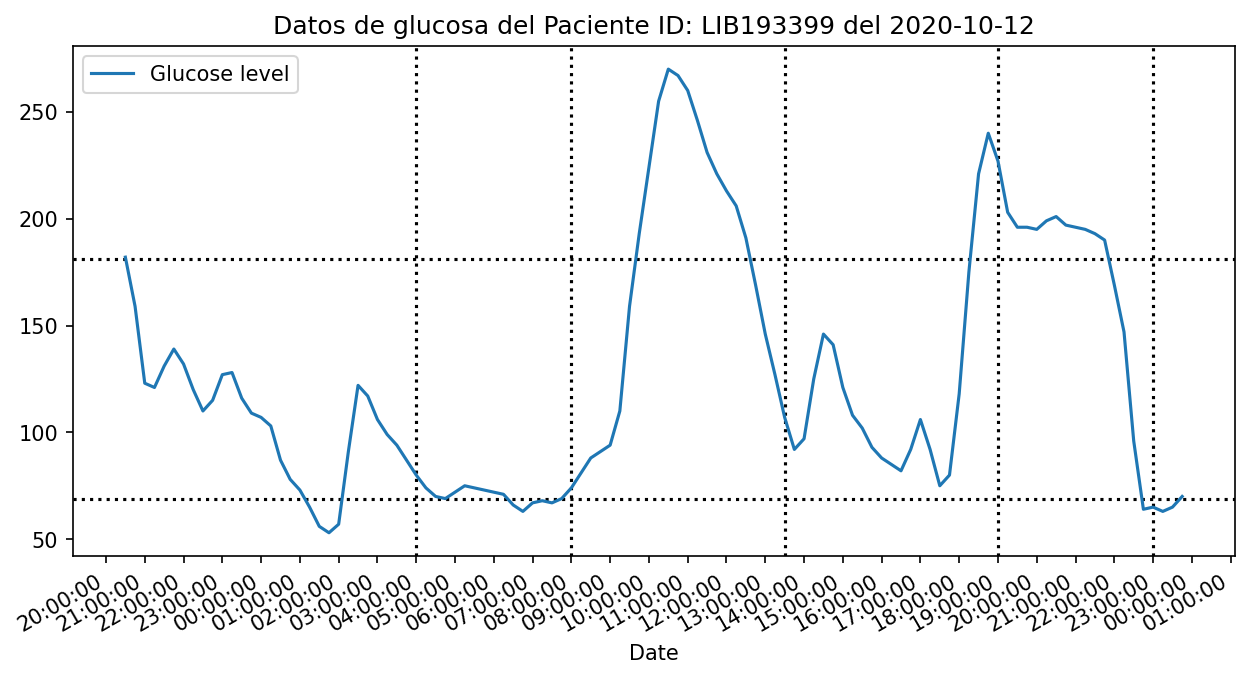

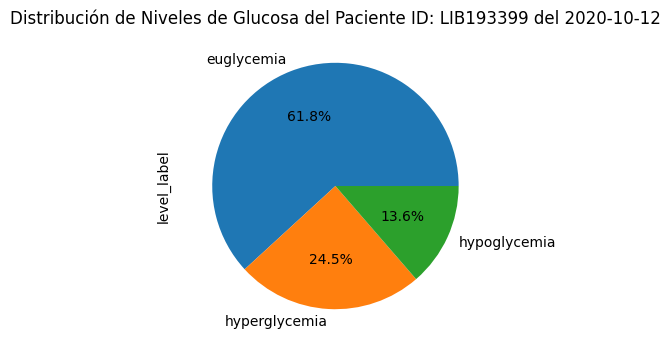

In [35]:
dateObj='2020-10-12'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP1_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [36]:
df_rango.loc[dateObj+' 06:00:00':dateObj+' 08:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-10-12 06:00:00,72.0,6,0,1,0,euglycemia
2020-10-12 06:15:00,71.0,6,15,1,0,euglycemia
2020-10-12 06:30:00,66.0,6,30,1,-1,hypoglycemia
2020-10-12 06:45:00,63.0,6,45,1,-1,hypoglycemia
2020-10-12 07:00:00,67.0,7,0,1,-1,hypoglycemia
2020-10-12 07:15:00,68.0,7,15,1,-1,hypoglycemia
2020-10-12 07:30:00,67.0,7,30,1,-1,hypoglycemia
2020-10-12 07:45:00,69.0,7,45,1,-1,hypoglycemia
2020-10-12 08:00:00,74.0,8,0,1,0,euglycemia


In [37]:
especialesP1.append('2020-10-12 06:30:00')

In [38]:
diasP1

['2020-10-16', '2020-10-3', '2020-10-10', '2020-10-12']

In [39]:
especialesP1

['2020-10-16 20:45:00',
 '2020-10-03 21:00:00',
 '2020-10-10 19:45:00',
 '2020-10-12 06:30:00']

## Pacientes del Q2

In [40]:
dfPacienteCount[dfPacienteCount['Freq'].between(6717,17889)]

,Freq
LIB193318,17889
LIB193351,17599
LIB193308,17178
LIB193273,16575
LIB193361,16448
LIB193346,16213
LIB193312,16155
LIB193372,15782
LIB193358,15146
LIB193317,14896


'LIB193353' tiene 13083 muestras

In [41]:
ID_Paciente=pq2='LIB193353'


diasP2=[]
especialesP2=[]

In [42]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [43]:
dfpaciente

,ID,Date,Glucose level
1967092,LIB193353,2021-04-20 18:25:00,180.0
1967093,LIB193353,2021-04-20 18:40:00,176.0
1967094,LIB193353,2021-04-20 18:55:00,178.0
1967095,LIB193353,2021-04-20 19:11:00,180.0
1967096,LIB193353,2021-04-20 19:25:00,172.0
...,...,...,...
1980170,LIB193353,2021-10-19 10:15:00,116.0
1980171,LIB193353,2021-10-19 10:30:00,117.0
1980172,LIB193353,2021-10-19 10:45:00,114.0
1980173,LIB193353,2021-10-19 11:00:00,101.0


In [44]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [45]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-04-20 18:15:00,180.0,18,15,4,0,euglycemia
2021-04-20 18:30:00,176.0,18,30,4,0,euglycemia
2021-04-20 18:45:00,178.0,18,45,4,0,euglycemia
2021-04-20 19:00:00,180.0,19,0,4,0,euglycemia
2021-04-20 19:15:00,172.0,19,15,4,0,euglycemia
...,...,...,...,...,...,...
2021-10-19 10:15:00,116.0,10,15,2,0,euglycemia
2021-10-19 10:30:00,117.0,10,30,2,0,euglycemia
2021-10-19 10:45:00,114.0,10,45,2,0,euglycemia


In [46]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2021-04-20 18:15:00,0.304348,0.782609,0.254237,0.6,0.5
2021-04-20 18:30:00,0.295652,0.782609,0.508475,0.6,0.5
2021-04-20 18:45:00,0.300000,0.782609,0.762712,0.6,0.5
2021-04-20 19:00:00,0.304348,0.826087,0.000000,0.6,0.5
2021-04-20 19:15:00,0.286957,0.826087,0.254237,0.6,0.5
...,...,...,...,...,...
2021-10-19 10:15:00,0.165217,0.434783,0.254237,0.2,0.5
2021-10-19 10:30:00,0.167391,0.434783,0.508475,0.2,0.5
2021-10-19 10:45:00,0.160870,0.434783,0.762712,0.2,0.5


### Análisis del Paciente 2: ID: LIB193353

<AxesSubplot: ylabel='level_label'>

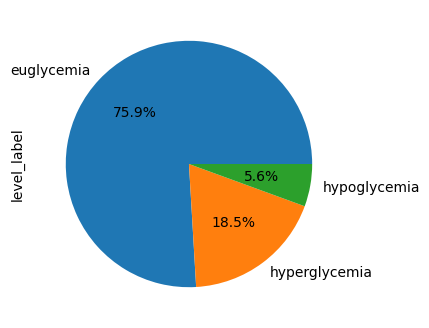

In [47]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 2: ID: LIB193353

Fecha Inicio Previo  : 2021-04-23 20:30:00
Rango Inicio Objetivo: 2021-04-24 04:00:00
Rango Fin Objetivo   : 2021-04-24 23:59:59


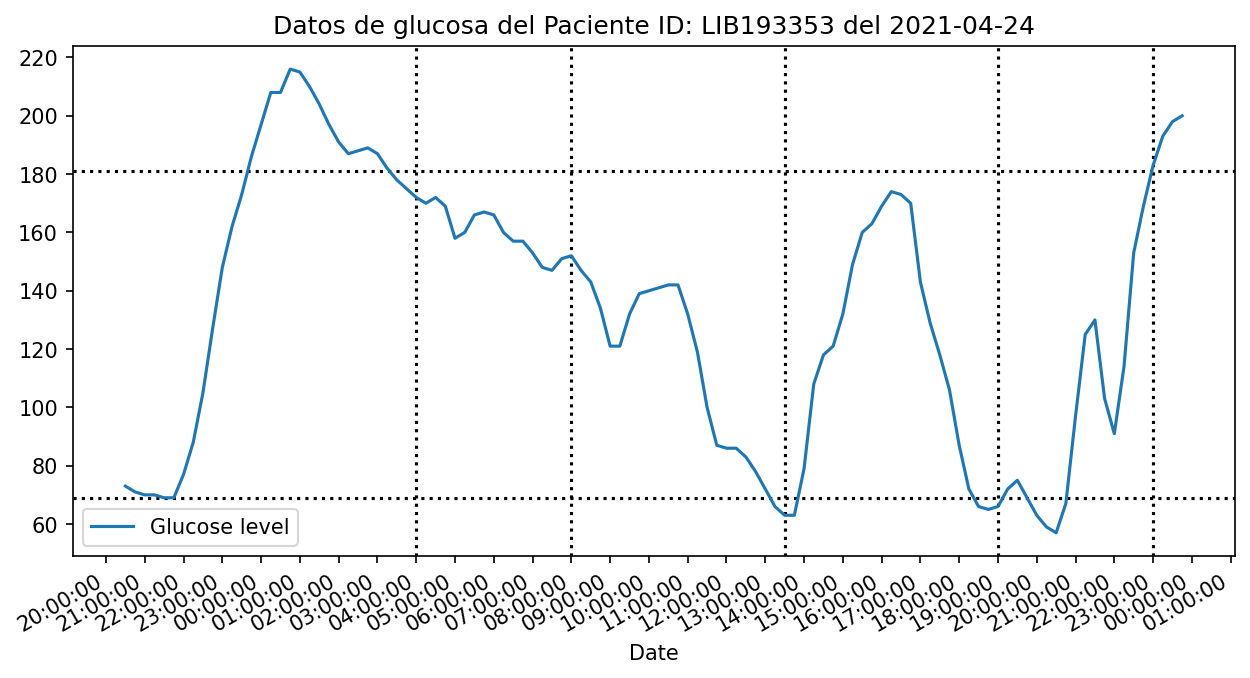

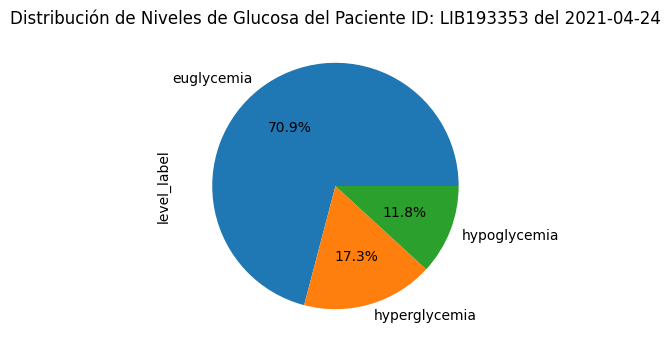

In [48]:
dateObj='2021-04-24'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [49]:
df_rango.loc[dateObj+' 19:00:00':dateObj+' 21:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-04-24 19:00:00,66.0,19,0,4,-1,hypoglycemia
2021-04-24 19:15:00,72.0,19,15,4,0,euglycemia
2021-04-24 19:30:00,75.0,19,30,4,0,euglycemia
2021-04-24 19:45:00,69.0,19,45,4,-1,hypoglycemia
2021-04-24 20:00:00,63.0,20,0,4,-1,hypoglycemia
2021-04-24 20:15:00,59.0,20,15,4,-1,hypoglycemia
2021-04-24 20:30:00,57.0,20,30,4,-1,hypoglycemia
2021-04-24 20:45:00,67.0,20,45,4,-1,hypoglycemia
2021-04-24 21:00:00,97.0,21,0,5,0,euglycemia


In [50]:
especialesP2.append('2021-04-24 19:45:00')

### Selección del Dia 2 del Paciente 2: ID: LIB193353

Fecha Inicio Previo  : 2021-04-30 20:30:00
Rango Inicio Objetivo: 2021-05-1 04:00:00
Rango Fin Objetivo   : 2021-05-1 23:59:59


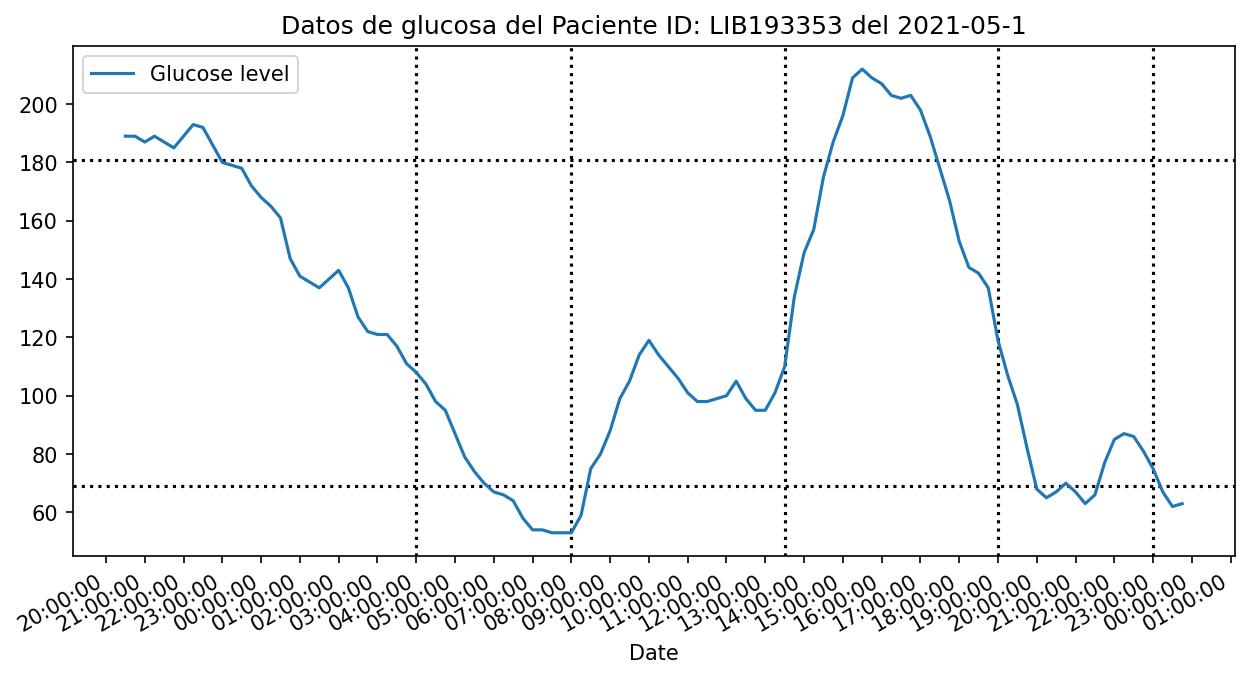

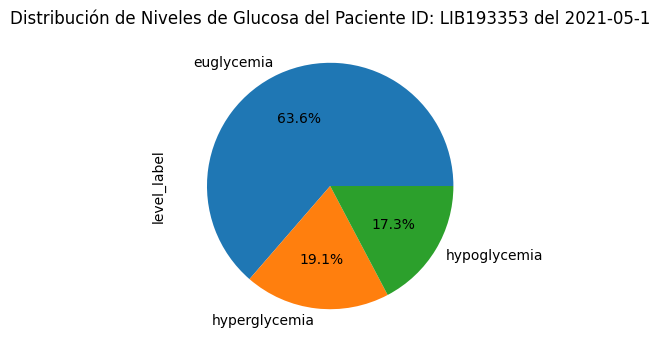

In [51]:
dateObj='2021-05-1'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [52]:
df_rango.loc[dateObj+' 19:00:00':dateObj+' 21:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-05-01 19:00:00,119.0,19,0,4,0,euglycemia
2021-05-01 19:15:00,107.0,19,15,4,0,euglycemia
2021-05-01 19:30:00,97.0,19,30,4,0,euglycemia
2021-05-01 19:45:00,82.0,19,45,4,0,euglycemia
2021-05-01 20:00:00,68.0,20,0,4,-1,hypoglycemia
2021-05-01 20:15:00,65.0,20,15,4,-1,hypoglycemia
2021-05-01 20:30:00,67.0,20,30,4,-1,hypoglycemia
2021-05-01 20:45:00,70.0,20,45,4,0,euglycemia
2021-05-01 21:00:00,67.0,21,0,5,-1,hypoglycemia


In [53]:
especialesP2.append('2021-05-01 20:00:00')

### Selección del Dia 3 del Paciente 2: ID: LIB193353

Fecha Inicio Previo  : 2021-05-15 20:30:00
Rango Inicio Objetivo: 2021-05-16 04:00:00
Rango Fin Objetivo   : 2021-05-16 23:59:59


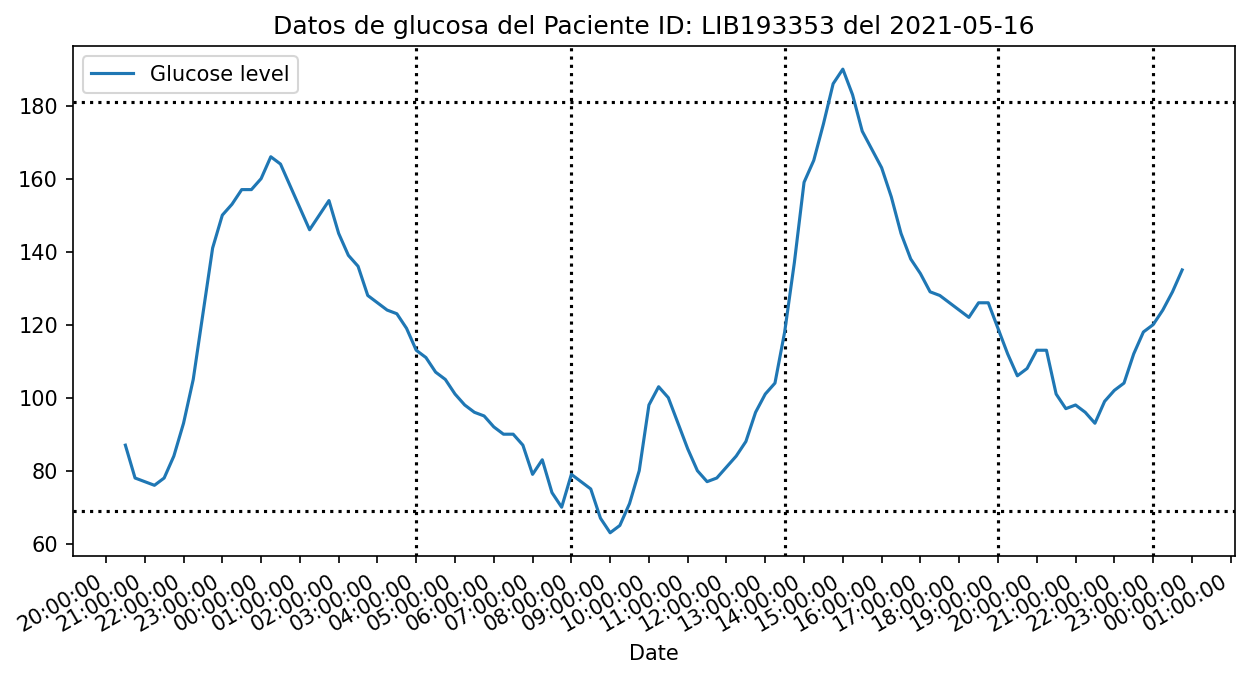

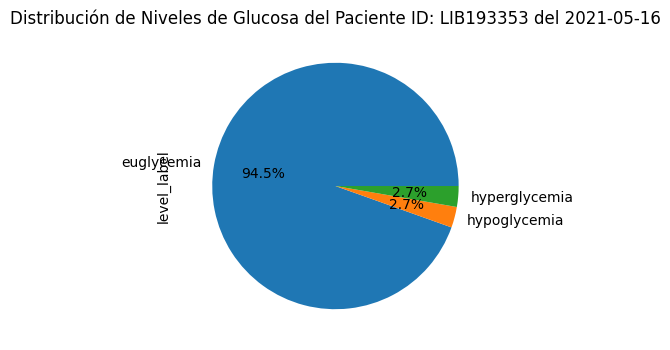

In [54]:
dateObj='2021-05-16'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [55]:
df_rango.loc[dateObj+' 08:00:00':dateObj+' 10:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-05-16 08:00:00,79.0,8,0,1,0,euglycemia
2021-05-16 08:15:00,77.0,8,15,1,0,euglycemia
2021-05-16 08:30:00,75.0,8,30,1,0,euglycemia
2021-05-16 08:45:00,67.0,8,45,1,-1,hypoglycemia
2021-05-16 09:00:00,63.0,9,0,2,-1,hypoglycemia
2021-05-16 09:15:00,65.0,9,15,2,-1,hypoglycemia
2021-05-16 09:30:00,71.0,9,30,2,0,euglycemia
2021-05-16 09:45:00,80.0,9,45,2,0,euglycemia
2021-05-16 10:00:00,98.0,10,0,2,0,euglycemia


In [56]:
especialesP2.append('2021-05-16 08:45:00')

### Selección del Dia 4 del Paciente 2: ID: LIB193353

Fecha Inicio Previo  : 2021-07-29 20:30:00
Rango Inicio Objetivo: 2021-07-30 04:00:00
Rango Fin Objetivo   : 2021-07-30 23:59:59


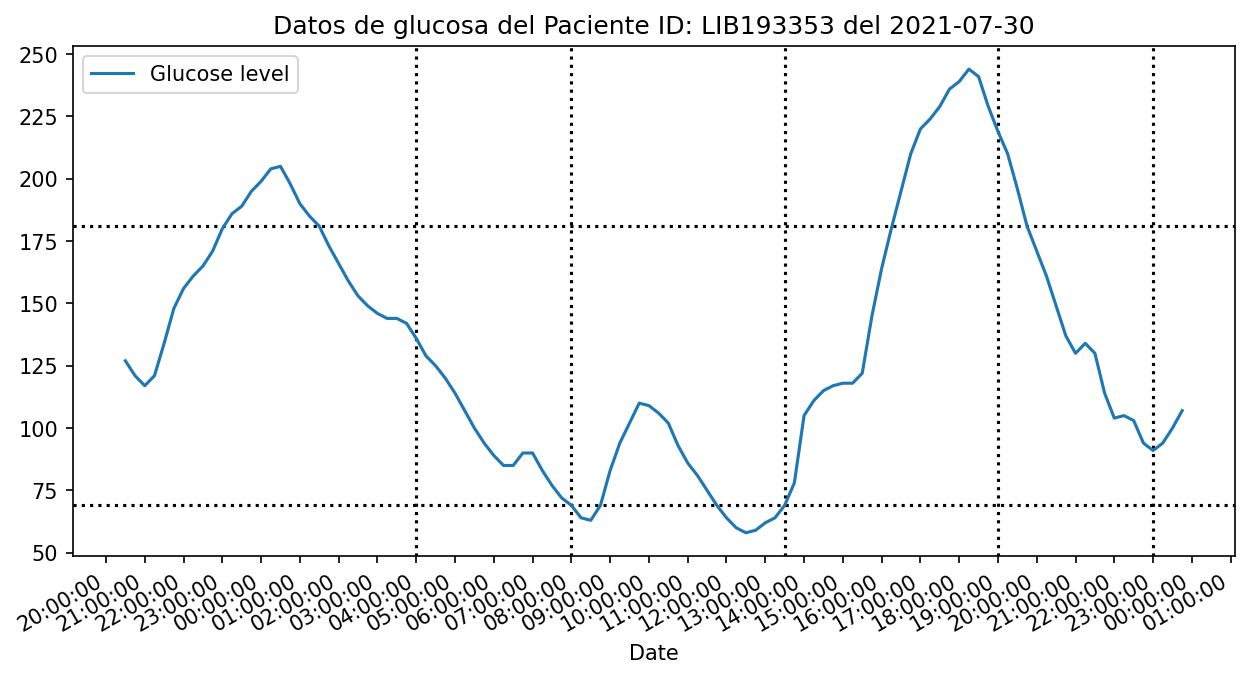

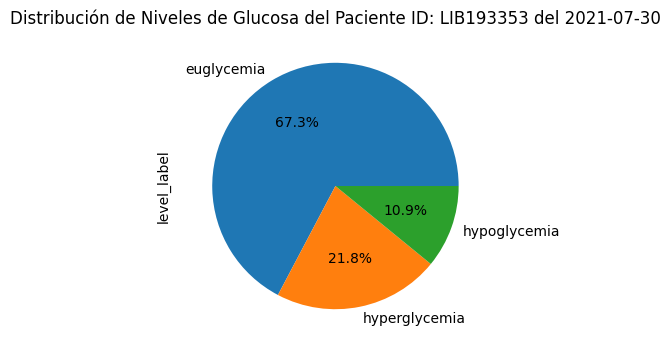

In [57]:
dateObj='2021-07-30'
diasP2.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP2_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [58]:
df_rango.loc[dateObj+' 11:30:00':dateObj+' 14:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-07-30 11:30:00,75.0,11,30,2,0,euglycemia
2021-07-30 11:45:00,69.0,11,45,2,-1,hypoglycemia
2021-07-30 12:00:00,64.0,12,0,2,-1,hypoglycemia
2021-07-30 12:15:00,60.0,12,15,2,-1,hypoglycemia
2021-07-30 12:30:00,58.0,12,30,2,-1,hypoglycemia
2021-07-30 12:45:00,59.0,12,45,2,-1,hypoglycemia
2021-07-30 13:00:00,62.0,13,0,3,-1,hypoglycemia
2021-07-30 13:15:00,64.0,13,15,3,-1,hypoglycemia
2021-07-30 13:30:00,69.0,13,30,3,-1,hypoglycemia


In [59]:
especialesP2.append('2021-07-30 11:45:00')

In [60]:
diasP2

['2021-04-24', '2021-05-1', '2021-05-16', '2021-07-30']

In [61]:
especialesP2

['2021-04-24 19:45:00',
 '2021-05-01 20:00:00',
 '2021-05-16 08:45:00',
 '2021-07-30 11:45:00']

## Pacientes del Q3

In [62]:
dfPacienteCount[dfPacienteCount['Freq'].between(17889,41868)]

,Freq
LIB193391,41790
LIB193268,41073
LIB193380,37553
LIB193320,37172
LIB193347,36456
LIB193382,36130
LIB193354,35086
LIB193305,34549
LIB193339,33071
LIB193384,32368


'LIB193315' tiene 31592 muestras

In [63]:
ID_Paciente=pq3='LIB193315'


diasP3=[]
especialesP3=[]

In [64]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [65]:
dfpaciente

,ID,Date,Glucose level
1166570,LIB193315,2021-03-09 12:04:00,99.0
1166571,LIB193315,2021-03-09 12:19:00,89.0
1166572,LIB193315,2021-03-09 12:34:00,80.0
1166573,LIB193315,2021-03-09 12:49:00,87.0
1166574,LIB193315,2021-03-09 13:05:00,102.0
...,...,...,...
1198157,LIB193315,2022-03-18 06:11:00,188.0
1198158,LIB193315,2022-03-18 06:26:00,182.0
1198159,LIB193315,2022-03-18 06:41:00,171.0
1198160,LIB193315,2022-03-18 06:56:00,167.0


In [66]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [67]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-03-09 12:00:00,99.0,12,0,2,0,euglycemia
2021-03-09 12:15:00,89.0,12,15,2,0,euglycemia
2021-03-09 12:30:00,80.0,12,30,2,0,euglycemia
2021-03-09 12:45:00,87.0,12,45,2,0,euglycemia
2021-03-09 13:00:00,102.0,13,0,3,0,euglycemia
...,...,...,...,...,...,...
2022-03-18 06:00:00,188.0,6,0,1,1,hyperglycemia
2022-03-18 06:15:00,182.0,6,15,1,1,hyperglycemia
2022-03-18 06:30:00,171.0,6,30,1,0,euglycemia


In [68]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2021-03-09 12:00:00,0.128261,0.521739,0.000000,0.2,0.5
2021-03-09 12:15:00,0.106522,0.521739,0.254237,0.2,0.5
2021-03-09 12:30:00,0.086957,0.521739,0.508475,0.2,0.5
2021-03-09 12:45:00,0.102174,0.521739,0.762712,0.2,0.5
2021-03-09 13:00:00,0.134783,0.565217,0.000000,0.4,0.5
...,...,...,...,...,...
2022-03-18 06:00:00,0.321739,0.260870,0.000000,0.0,1.0
2022-03-18 06:15:00,0.308696,0.260870,0.254237,0.0,1.0
2022-03-18 06:30:00,0.284783,0.260870,0.508475,0.0,0.5


### Análisis del Paciente 3: ID: LIB193315

<AxesSubplot: ylabel='level_label'>

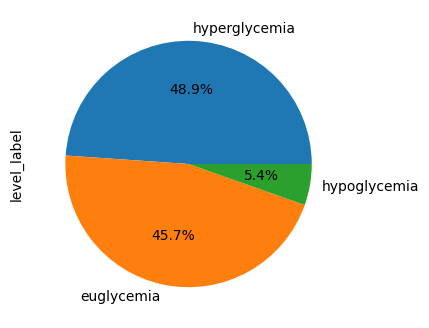

In [69]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-03-11 20:30:00
Rango Inicio Objetivo: 2021-03-12 04:00:00
Rango Fin Objetivo   : 2021-03-12 23:59:59


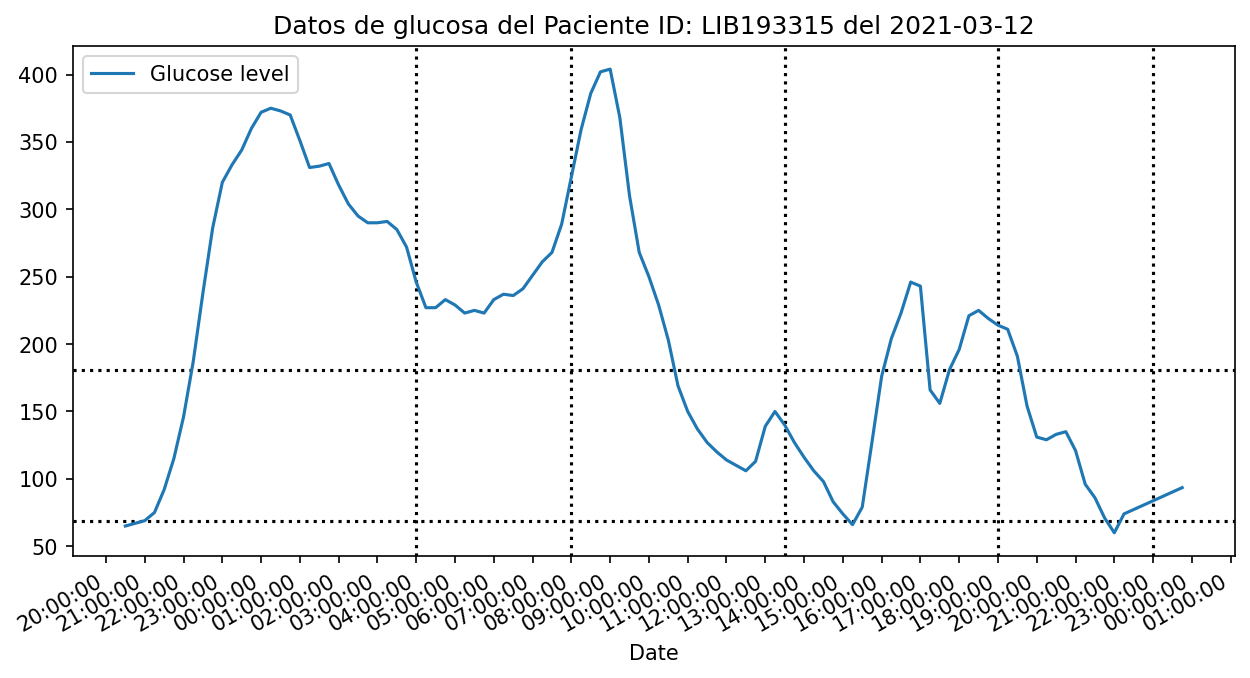

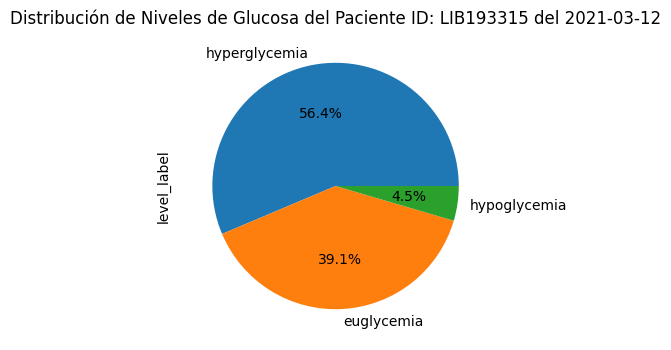

In [70]:
dateObj='2021-03-12'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [71]:
df_rango.loc[dateObj+' 21:00:00':dateObj+' 23:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-03-12 21:00:00,121.00,21,0,5,0,euglycemia
2021-03-12 21:15:00,96.00,21,15,5,0,euglycemia
2021-03-12 21:30:00,86.00,21,30,5,0,euglycemia
2021-03-12 21:45:00,71.00,21,45,5,0,euglycemia
2021-03-12 22:00:00,60.00,22,0,5,-1,hypoglycemia
2021-03-12 22:15:00,74.00,22,15,5,0,euglycemia
2021-03-12 22:30:00,77.25,22,30,5,0,euglycemia
2021-03-12 22:45:00,80.50,22,45,5,0,euglycemia
2021-03-12 23:00:00,83.75,23,0,5,0,euglycemia


In [72]:
especialesP3.append('2021-03-12 22:00:00')

### Selección del Dia 2 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-03-17 20:30:00
Rango Inicio Objetivo: 2021-03-18 04:00:00
Rango Fin Objetivo   : 2021-03-18 23:59:59


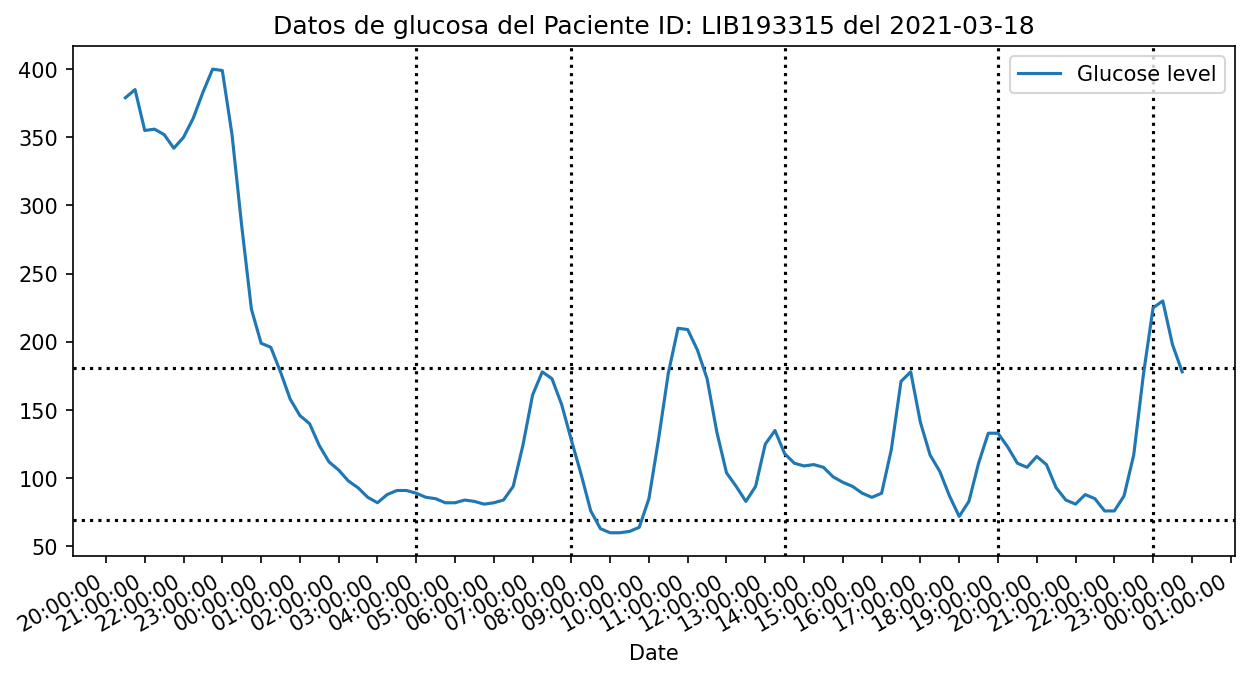

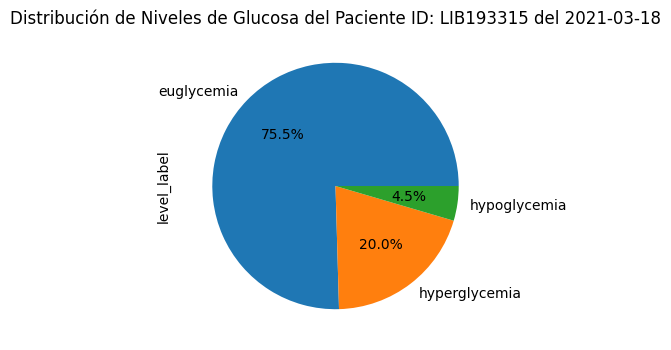

In [73]:
dateObj='2021-03-18'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [74]:
df_rango.loc[dateObj+' 08:00:00':dateObj+' 10:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-03-18 08:00:00,128.0,8,0,1,0,euglycemia
2021-03-18 08:15:00,103.0,8,15,1,0,euglycemia
2021-03-18 08:30:00,76.0,8,30,1,0,euglycemia
2021-03-18 08:45:00,63.0,8,45,1,-1,hypoglycemia
2021-03-18 09:00:00,60.0,9,0,2,-1,hypoglycemia
2021-03-18 09:15:00,60.0,9,15,2,-1,hypoglycemia
2021-03-18 09:30:00,61.0,9,30,2,-1,hypoglycemia
2021-03-18 09:45:00,64.0,9,45,2,-1,hypoglycemia
2021-03-18 10:00:00,85.0,10,0,2,0,euglycemia


In [75]:
especialesP3.append('2021-03-18 08:45:00')

### Selección del Dia 3 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-03-21 20:30:00
Rango Inicio Objetivo: 2021-03-22 04:00:00
Rango Fin Objetivo   : 2021-03-22 23:59:59


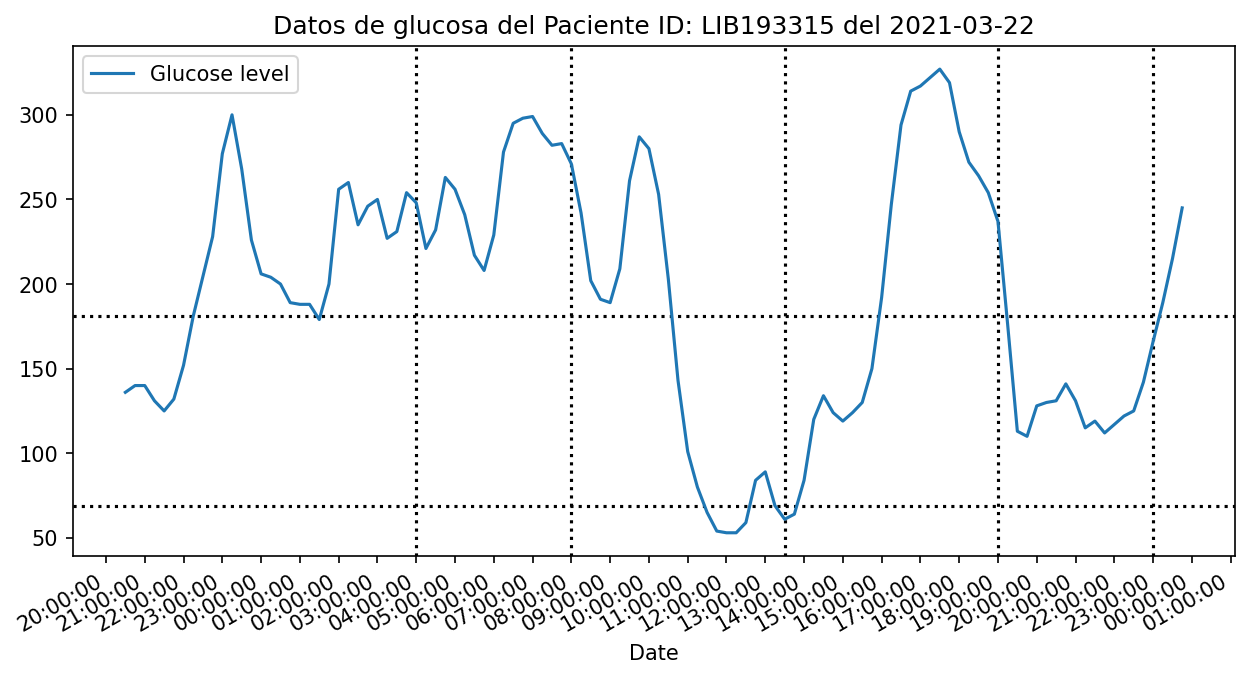

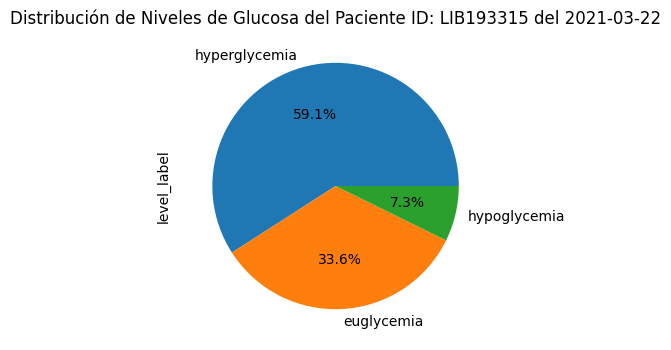

In [76]:
dateObj='2021-03-22'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [77]:
df_rango.loc[dateObj+' 11:00:00':dateObj+' 13:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-03-22 11:00:00,101.0,11,0,2,0,euglycemia
2021-03-22 11:15:00,80.0,11,15,2,0,euglycemia
2021-03-22 11:30:00,65.0,11,30,2,-1,hypoglycemia
2021-03-22 11:45:00,54.0,11,45,2,-1,hypoglycemia
2021-03-22 12:00:00,53.0,12,0,2,-1,hypoglycemia
2021-03-22 12:15:00,53.0,12,15,2,-1,hypoglycemia
2021-03-22 12:30:00,59.0,12,30,2,-1,hypoglycemia
2021-03-22 12:45:00,84.0,12,45,2,0,euglycemia
2021-03-22 13:00:00,89.0,13,0,3,0,euglycemia


In [78]:
especialesP3.append('2021-03-22 11:30:00')

### Selección del Dia 4 del Paciente 3: ID: LIB193315

Fecha Inicio Previo  : 2021-04-10 20:30:00
Rango Inicio Objetivo: 2021-04-11 04:00:00
Rango Fin Objetivo   : 2021-04-11 23:59:59


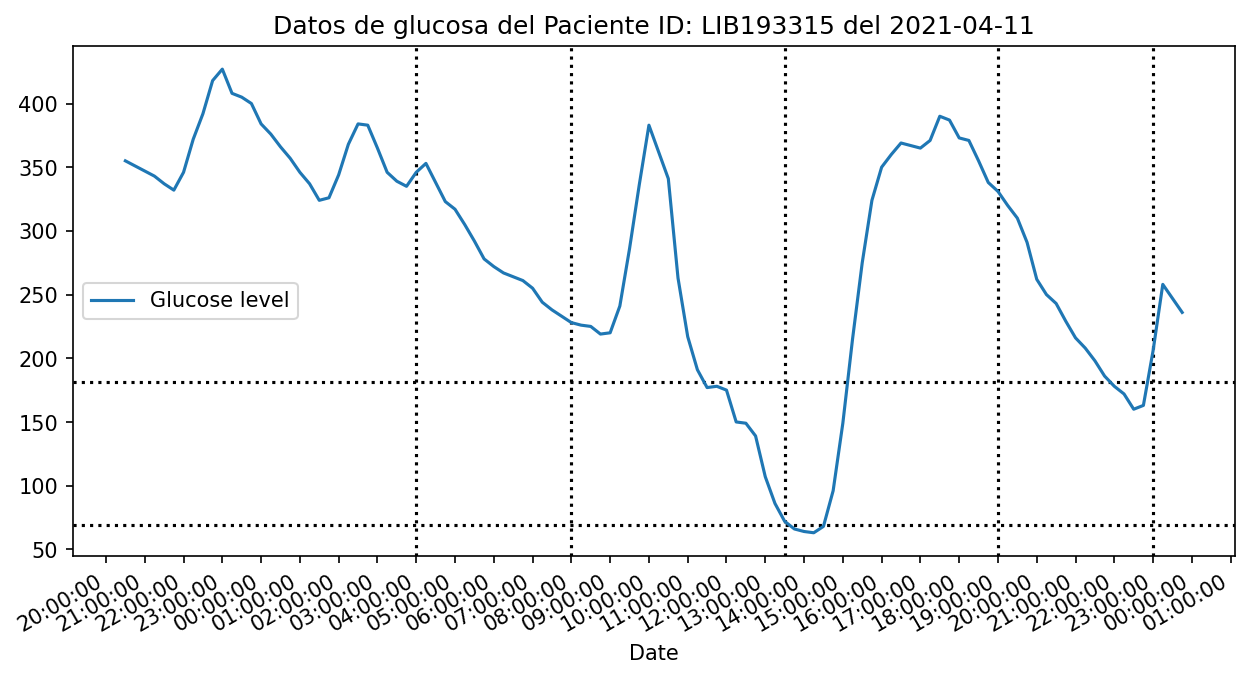

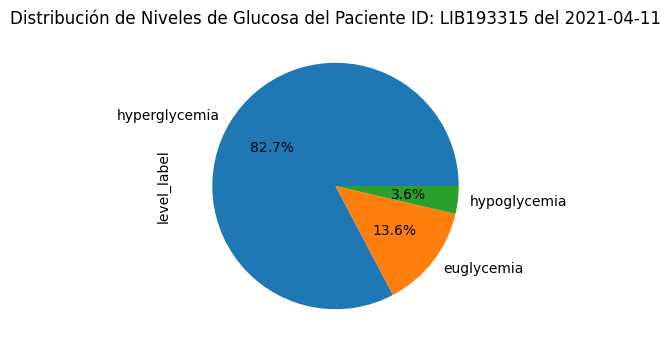

In [79]:
dateObj='2021-04-11'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP3_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [80]:
df_rango.loc[dateObj+' 13:00:00':dateObj+' 15:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-04-11 13:00:00,107.0,13,0,3,0,euglycemia
2021-04-11 13:15:00,86.0,13,15,3,0,euglycemia
2021-04-11 13:30:00,72.0,13,30,3,0,euglycemia
2021-04-11 13:45:00,66.0,13,45,3,-1,hypoglycemia
2021-04-11 14:00:00,64.0,14,0,3,-1,hypoglycemia
2021-04-11 14:15:00,63.0,14,15,3,-1,hypoglycemia
2021-04-11 14:30:00,68.0,14,30,3,-1,hypoglycemia
2021-04-11 14:45:00,96.0,14,45,3,0,euglycemia
2021-04-11 15:00:00,149.0,15,0,3,0,euglycemia


In [81]:
especialesP3.append('2021-04-11 13:45:00')

In [82]:
diasP3

['2021-03-12', '2021-03-18', '2021-03-22', '2021-04-11']

In [83]:
especialesP3

['2021-03-12 22:00:00',
 '2021-03-18 08:45:00',
 '2021-03-22 11:30:00',
 '2021-04-11 13:45:00']

## Pacientes del Q4

In [84]:
dfPacienteCount[dfPacienteCount['Freq']>41868]

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
LIB193269,71853
LIB193310,71764
LIB193397,68945
LIB193342,64666
LIB193356,62847


'LIB193304' tiene 59786 muestras

In [85]:
ID_Paciente=pq4='LIB193304'


diasP4=[]
especialesP4=[]

In [86]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [87]:
dfpaciente

,ID,Date,Glucose level
667394,LIB193304,2020-06-10 17:59:00,192.0
667395,LIB193304,2020-06-10 18:14:00,187.0
667396,LIB193304,2020-06-10 18:29:00,178.0
667397,LIB193304,2020-06-10 18:44:00,170.0
667398,LIB193304,2020-06-10 19:00:00,153.0
...,...,...,...
727175,LIB193304,2022-03-18 22:23:00,100.0
727176,LIB193304,2022-03-18 22:38:00,89.0
727177,LIB193304,2022-03-18 22:53:00,92.0
727178,LIB193304,2022-03-18 23:08:00,106.0


In [88]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [89]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-06-10 17:45:00,192.0,17,45,4,1,hyperglycemia
2020-06-10 18:00:00,187.0,18,0,4,1,hyperglycemia
2020-06-10 18:15:00,178.0,18,15,4,0,euglycemia
2020-06-10 18:30:00,170.0,18,30,4,0,euglycemia
2020-06-10 18:45:00,161.5,18,45,4,0,euglycemia
...,...,...,...,...,...,...
2022-03-18 22:15:00,100.0,22,15,5,0,euglycemia
2022-03-18 22:30:00,89.0,22,30,5,0,euglycemia
2022-03-18 22:45:00,92.0,22,45,5,0,euglycemia


In [90]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2020-06-10 17:45:00,0.330435,0.739130,0.762712,0.6,1.0
2020-06-10 18:00:00,0.319565,0.782609,0.000000,0.6,1.0
2020-06-10 18:15:00,0.300000,0.782609,0.254237,0.6,0.5
2020-06-10 18:30:00,0.282609,0.782609,0.508475,0.6,0.5
2020-06-10 18:45:00,0.264130,0.782609,0.762712,0.6,0.5
...,...,...,...,...,...
2022-03-18 22:15:00,0.130435,0.956522,0.254237,0.8,0.5
2022-03-18 22:30:00,0.106522,0.956522,0.508475,0.8,0.5
2022-03-18 22:45:00,0.113043,0.956522,0.762712,0.8,0.5


### Análisis del Paciente 4: ID: LIB193341

<AxesSubplot: ylabel='level_label'>

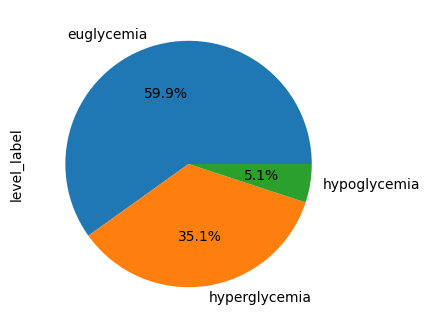

In [91]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-06-15 20:30:00
Rango Inicio Objetivo: 2020-06-16 04:00:00
Rango Fin Objetivo   : 2020-06-16 23:59:59


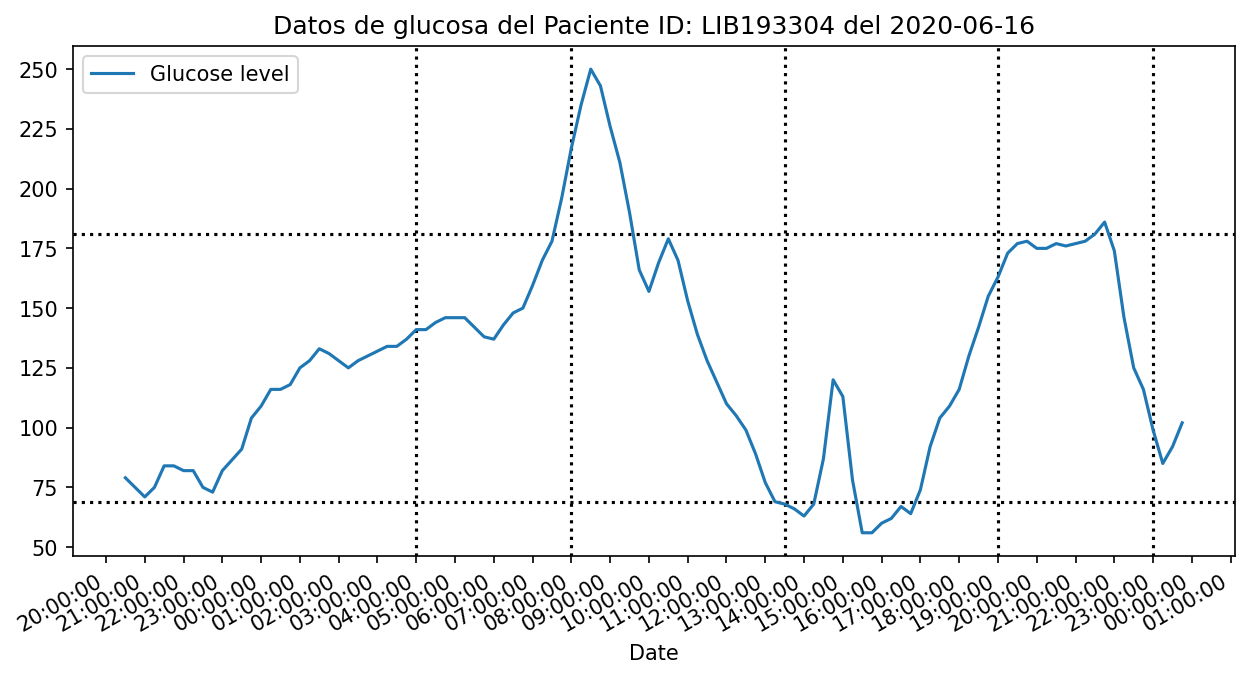

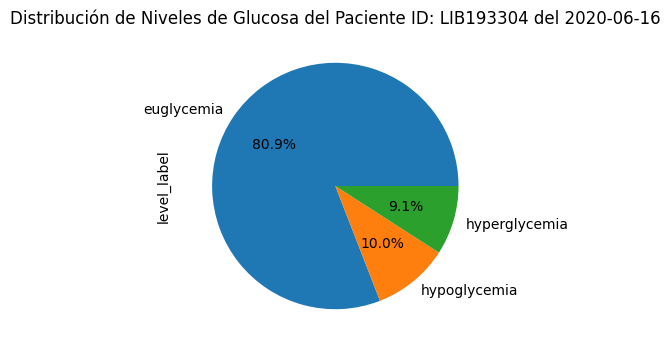

In [92]:
dateObj='2020-06-16'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d1=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [93]:
df_rango.loc[dateObj+' 15:00:00':dateObj+' 17:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-06-16 15:00:00,113.0,15,0,3,0,euglycemia
2020-06-16 15:15:00,78.0,15,15,3,0,euglycemia
2020-06-16 15:30:00,56.0,15,30,3,-1,hypoglycemia
2020-06-16 15:45:00,56.0,15,45,3,-1,hypoglycemia
2020-06-16 16:00:00,60.0,16,0,3,-1,hypoglycemia
2020-06-16 16:15:00,62.0,16,15,3,-1,hypoglycemia
2020-06-16 16:30:00,67.0,16,30,3,-1,hypoglycemia
2020-06-16 16:45:00,64.0,16,45,3,-1,hypoglycemia
2020-06-16 17:00:00,74.0,17,0,4,0,euglycemia


In [94]:
especialesP4.append('2020-06-16 15:30:00')

### Selección del Dia 2 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-06-17 20:30:00
Rango Inicio Objetivo: 2020-06-18 04:00:00
Rango Fin Objetivo   : 2020-06-18 23:59:59


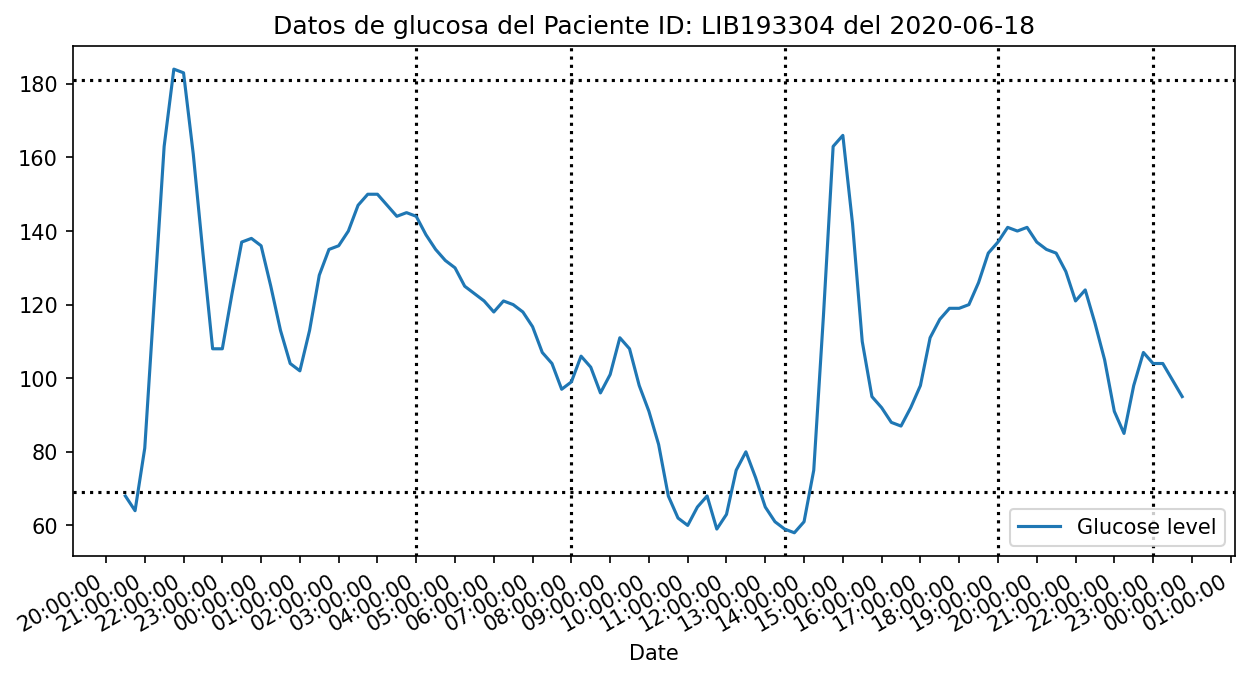

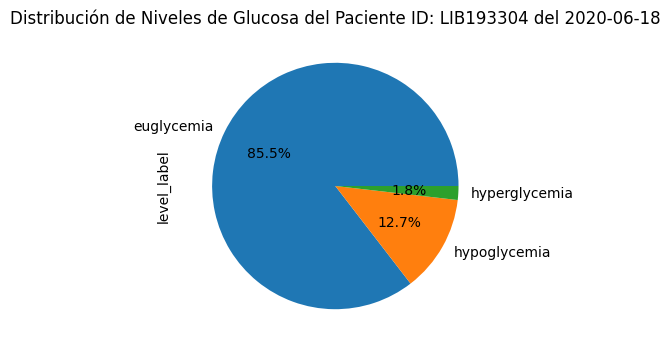

In [95]:
dateObj='2020-06-18'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d2=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [96]:
df_rango.loc[dateObj+' 10:00:00':dateObj+' 13:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-06-18 10:00:00,91.0,10,0,2,0,euglycemia
2020-06-18 10:15:00,82.0,10,15,2,0,euglycemia
2020-06-18 10:30:00,68.0,10,30,2,-1,hypoglycemia
2020-06-18 10:45:00,62.0,10,45,2,-1,hypoglycemia
2020-06-18 11:00:00,60.0,11,0,2,-1,hypoglycemia
2020-06-18 11:15:00,65.0,11,15,2,-1,hypoglycemia
2020-06-18 11:30:00,68.0,11,30,2,-1,hypoglycemia
2020-06-18 11:45:00,59.0,11,45,2,-1,hypoglycemia
2020-06-18 12:00:00,63.0,12,0,2,-1,hypoglycemia


In [97]:
especialesP4.append('2020-06-18 10:30:00')

### Selección del Dia 3 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-06-20 20:30:00
Rango Inicio Objetivo: 2020-06-21 04:00:00
Rango Fin Objetivo   : 2020-06-21 23:59:59


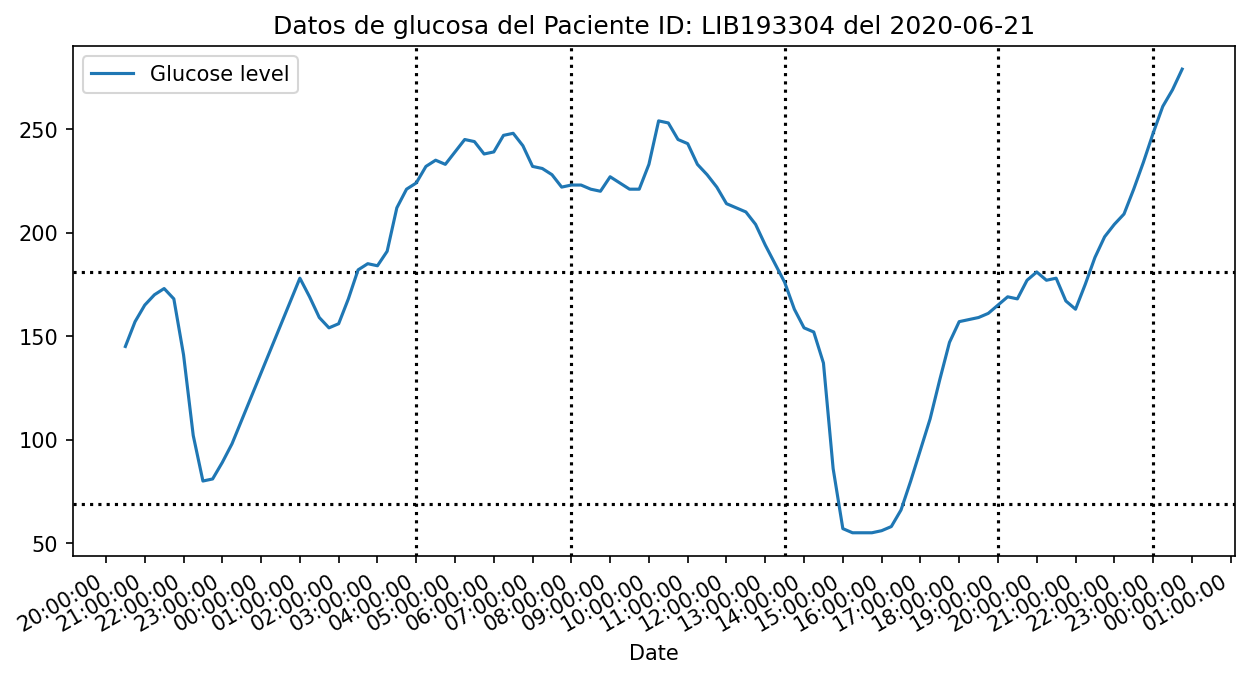

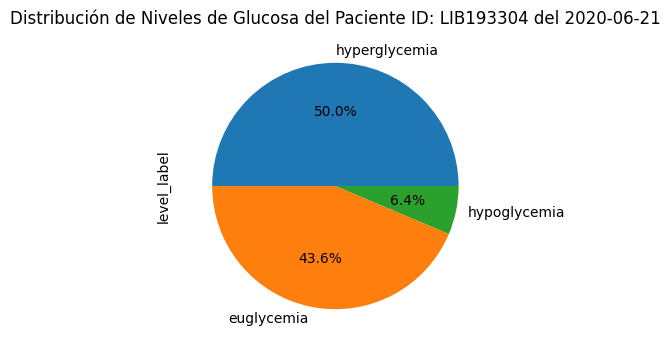

In [98]:
dateObj='2020-06-21'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d3=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [99]:
df_rango.loc[dateObj+' 14:00:00':dateObj+' 17:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-06-21 14:00:00,154.0,14,0,3,0,euglycemia
2020-06-21 14:15:00,152.0,14,15,3,0,euglycemia
2020-06-21 14:30:00,137.0,14,30,3,0,euglycemia
2020-06-21 14:45:00,86.0,14,45,3,0,euglycemia
2020-06-21 15:00:00,57.0,15,0,3,-1,hypoglycemia
2020-06-21 15:15:00,55.0,15,15,3,-1,hypoglycemia
2020-06-21 15:30:00,55.0,15,30,3,-1,hypoglycemia
2020-06-21 15:45:00,55.0,15,45,3,-1,hypoglycemia
2020-06-21 16:00:00,56.0,16,0,3,-1,hypoglycemia


In [100]:
especialesP4.append('2020-06-21 15:00:00')

### Selección del Dia 4 del Paciente 4: ID: LIB193304

Fecha Inicio Previo  : 2020-07-03 20:30:00
Rango Inicio Objetivo: 2020-07-04 04:00:00
Rango Fin Objetivo   : 2020-07-04 23:59:59


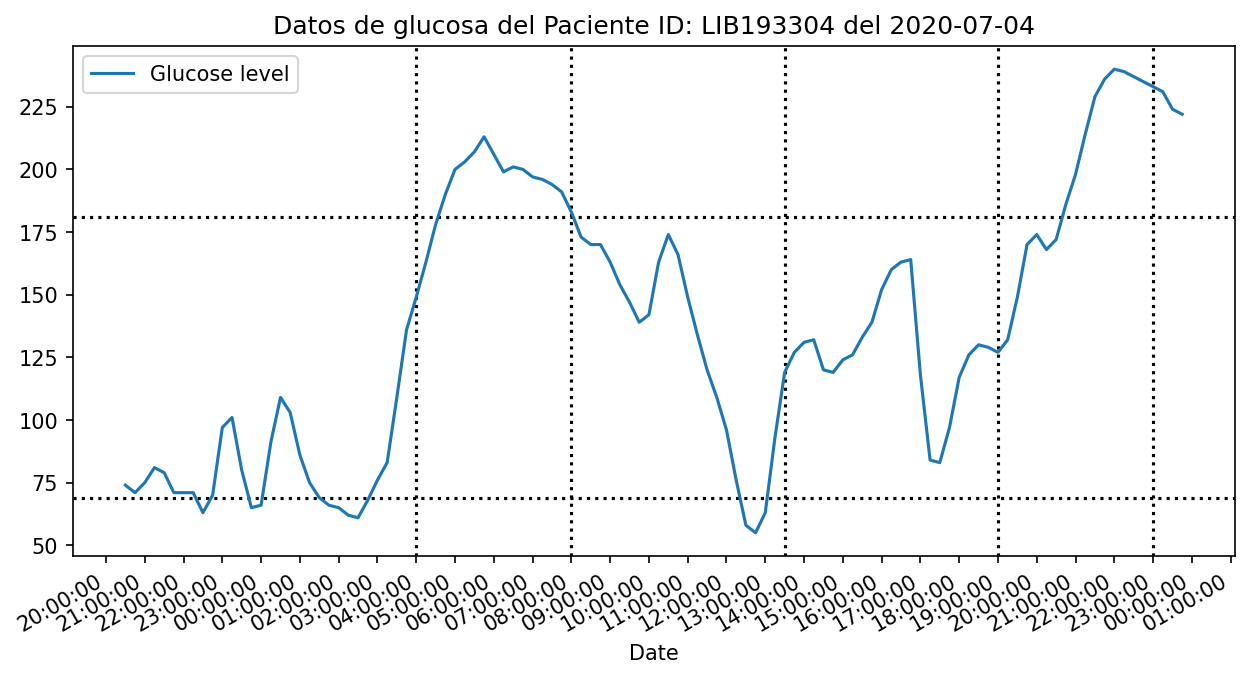

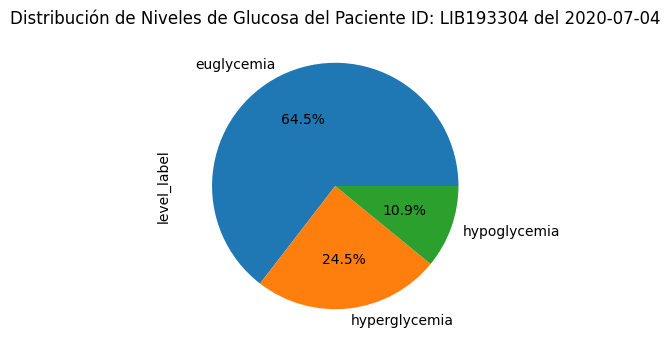

In [101]:
dateObj='2020-07-04'
diasP4.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGenPaciente.loc[DateObjStart:ObjRangeDateEnd]
utils.plotDayPatient(df_rango,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)
df_rango['level_label'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
dfP4_d4=dfGenPacienteScaled.loc[DateObjStart:ObjRangeDateEnd].copy()

### Agregamos eventos especiales de hipoglucemia

In [102]:
df_rango.loc[dateObj+' 11:00:00':dateObj+' 14:00:00']

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-07-04 11:00:00,149.0,11,0,2,0,euglycemia
2020-07-04 11:15:00,134.0,11,15,2,0,euglycemia
2020-07-04 11:30:00,120.0,11,30,2,0,euglycemia
2020-07-04 11:45:00,109.0,11,45,2,0,euglycemia
2020-07-04 12:00:00,96.0,12,0,2,0,euglycemia
2020-07-04 12:15:00,76.0,12,15,2,0,euglycemia
2020-07-04 12:30:00,58.0,12,30,2,-1,hypoglycemia
2020-07-04 12:45:00,55.0,12,45,2,-1,hypoglycemia
2020-07-04 13:00:00,63.0,13,0,3,-1,hypoglycemia


In [103]:
especialesP4.append('2020-07-04 12:30:00')

In [104]:
diasP4

['2020-06-16', '2020-06-18', '2020-06-21', '2020-07-04']

In [105]:
especialesP4

['2020-06-16 15:30:00',
 '2020-06-18 10:30:00',
 '2020-06-21 15:00:00',
 '2020-07-04 12:30:00']

## Unimos los dataset de los 4 dias seleccionados de cada paciente

In [106]:
dfP1 = pd.concat([dfP1_d1,dfP1_d2,dfP1_d3,dfP1_d4])
dfP2 = pd.concat([dfP2_d1,dfP2_d2,dfP2_d3,dfP2_d4])
dfP3 = pd.concat([dfP3_d1,dfP3_d2,dfP3_d3,dfP3_d4])
dfP4 = pd.concat([dfP4_d1,dfP4_d2,dfP4_d3,dfP4_d4])

## Prueba de recolección de los valores a predecir a las 4am

Hay que recordar que solo necesitamos 30 muestras hacia atras del objetivo, es decir 30*15min=450min o 7.5 horas antes

In [107]:
hora=' 04:00:00'
DateObj=diasP1[0]+hora
print(DateObj)
DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
print(DateObjStart)
df_rango=dfP1.loc[DateObjStart:DateObj]
print(len(df_rango))

2020-10-16 04:00:00
2020-10-15 20:30:00
31


In [108]:
df_rango

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2020-10-15 20:30:00,0.160870,0.869565,0.508475,0.6,0.5
2020-10-15 20:45:00,0.147826,0.869565,0.762712,0.6,0.5
2020-10-15 21:00:00,0.089130,0.913043,0.000000,0.8,0.5
2020-10-15 21:15:00,0.045652,0.913043,0.254237,0.8,0.0
2020-10-15 21:30:00,0.073913,0.913043,0.508475,0.8,0.5
2020-10-15 21:45:00,0.169565,0.913043,0.762712,0.8,0.5
2020-10-15 22:00:00,0.332609,0.956522,0.000000,0.8,1.0
2020-10-15 22:15:00,0.423913,0.956522,0.254237,0.8,1.0
2020-10-15 22:30:00,0.443478,0.956522,0.508475,0.8,1.0


## Probamos como se ven los datos que debe generar para entrenamiento

In [109]:
select_data=df_rango.to_numpy()
X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)

In [110]:
X

array([[[0.16086957, 0.86956522, 0.50847458, 0.6       , 0.5       ],
        [0.14782609, 0.86956522, 0.76271186, 0.6       , 0.5       ],
        [0.08913043, 0.91304348, 0.        , 0.8       , 0.5       ],
        [0.04565217, 0.91304348, 0.25423729, 0.8       , 0.        ],
        [0.07391304, 0.91304348, 0.50847458, 0.8       , 0.5       ],
        [0.16956522, 0.91304348, 0.76271186, 0.8       , 0.5       ],
        [0.3326087 , 0.95652174, 0.        , 0.8       , 1.        ],
        [0.42391304, 0.95652174, 0.25423729, 0.8       , 1.        ],
        [0.44347826, 0.95652174, 0.50847458, 0.8       , 1.        ],
        [0.37391304, 0.95652174, 0.76271186, 0.8       , 1.        ],
        [0.28913043, 1.        , 0.        , 0.8       , 0.5       ],
        [0.24782609, 1.        , 0.25423729, 0.8       , 0.5       ],
        [0.28478261, 1.        , 0.50847458, 0.8       , 0.5       ],
        [0.30869565, 1.        , 0.76271186, 0.8       , 1.        ],
        [0.29130435,

In [111]:
Y

array([[0.09565217]])

## Recolección de los eventos de forma automática

In [112]:
gen_X=np.reshape([], (0, lag, len(featuresObj)))
gen_Y=np.reshape([], (0,1))
print(gen_X.shape)
print(gen_Y.shape)

(0, 30, 5)
(0, 1)


### Recolección de Eventos fijos

In [113]:
gen_XP1=np.reshape([], (0, lag, len(featuresObj)))
gen_YP1=np.reshape([], (0,1))

gen_XP2=np.reshape([], (0, lag, len(featuresObj)))
gen_YP2=np.reshape([], (0,1))

gen_XP3=np.reshape([], (0, lag, len(featuresObj)))
gen_YP3=np.reshape([], (0,1))

gen_XP4=np.reshape([], (0, lag, len(featuresObj)))
gen_YP4=np.reshape([], (0,1))

eventosFijos=[' 04:00:00',' 08:00:00',' 13:30:00',' 19:00:00',' 23:00:00']

eventosP1=[]
eventosP2=[]
eventosP3=[]
eventosP4=[]
for evento in eventosFijos:
    print('Paciente 1')
    for dia in diasP1: 
        DateObj=dia+evento
        print(DateObj)
        eventosP1.append(DateObj)        
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP1.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP1=np.concatenate((gen_XP1,X))
        gen_YP1=np.concatenate((gen_YP1,Y)) 
    
    print('Paciente 2')
    for dia in diasP2: 
        DateObj=dia+evento
        print(DateObj)
        eventosP2.append(DateObj)       
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP2.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP2=np.concatenate((gen_XP2,X))
        gen_YP2=np.concatenate((gen_YP2,Y)) 
    
    print('Paciente 3')
    for dia in diasP3: 
        DateObj=dia+evento
        print(DateObj)
        eventosP3.append(DateObj)       
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP3.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP3=np.concatenate((gen_XP3,X))
        gen_YP3=np.concatenate((gen_YP3,Y)) 
    
    print('Paciente 4')
    for dia in diasP4: 
        DateObj=dia+evento
        print(DateObj)
        eventosP4.append(DateObj)       
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP4.loc[DateObjStart:DateObj]
        select_data=df_rango.to_numpy()
        X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
        gen_XP4=np.concatenate((gen_XP4,X))
        gen_YP4=np.concatenate((gen_YP4,Y)) 
        
print(len(gen_XP1))
print(len(gen_YP1))

print(len(gen_XP2))
print(len(gen_YP2))
print(len(gen_XP3))
print(len(gen_YP3))       

print(len(gen_XP4))
print(len(gen_YP4))

Paciente 1
2020-10-16 04:00:00
2020-10-3 04:00:00
2020-10-10 04:00:00
2020-10-12 04:00:00
Paciente 2
2021-04-24 04:00:00
2021-05-1 04:00:00
2021-05-16 04:00:00
2021-07-30 04:00:00
Paciente 3
2021-03-12 04:00:00
2021-03-18 04:00:00
2021-03-22 04:00:00
2021-04-11 04:00:00
Paciente 4
2020-06-16 04:00:00
2020-06-18 04:00:00
2020-06-21 04:00:00
2020-07-04 04:00:00
Paciente 1
2020-10-16 08:00:00
2020-10-3 08:00:00
2020-10-10 08:00:00
2020-10-12 08:00:00
Paciente 2
2021-04-24 08:00:00
2021-05-1 08:00:00
2021-05-16 08:00:00
2021-07-30 08:00:00
Paciente 3
2021-03-12 08:00:00
2021-03-18 08:00:00
2021-03-22 08:00:00
2021-04-11 08:00:00
Paciente 4
2020-06-16 08:00:00
2020-06-18 08:00:00
2020-06-21 08:00:00
2020-07-04 08:00:00
Paciente 1
2020-10-16 13:30:00
2020-10-3 13:30:00
2020-10-10 13:30:00
2020-10-12 13:30:00
Paciente 2
2021-04-24 13:30:00
2021-05-1 13:30:00
2021-05-16 13:30:00
2021-07-30 13:30:00
Paciente 3
2021-03-12 13:30:00
2021-03-18 13:30:00
2021-03-22 13:30:00
2021-04-11 13:30:00
Pacie

In [114]:
gen_X=np.concatenate((gen_XP1,gen_XP2,gen_XP3,gen_XP4))

In [115]:
gen_X.shape

(80, 30, 5)

In [116]:
gen_Y=np.concatenate((gen_YP1,gen_YP2,gen_YP3,gen_YP4))

In [117]:
gen_Y.shape

(80, 1)

In [118]:
dfResult=pd.DataFrame(scalerGlucosa.inverse_transform(gen_Y),columns=['Glucose level'])
dfResult['Nivel'] = dfResult['Glucose level'].apply(utils.label_LevelBG)   
dfResult

,Glucose level,Nivel
0,84.0,euglycemia
1,191.0,hyperglycemia
2,199.0,hyperglycemia
3,80.0,euglycemia
4,99.0,euglycemia
...,...,...
75,127.0,euglycemia
76,99.0,euglycemia
77,104.0,euglycemia
78,248.0,hyperglycemia


In [119]:
dfResult['Nivel'].value_counts()

euglycemia       46
hyperglycemia    24
hypoglycemia     10
Name: Nivel, dtype: int64

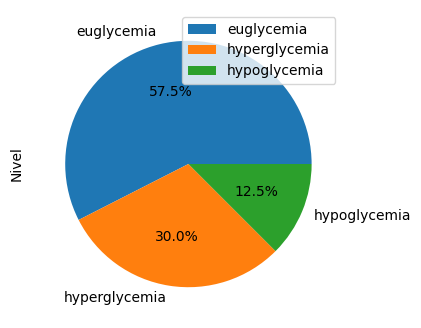

In [120]:
dfResult['Nivel'].value_counts().plot.pie(y='level_label',legend=True,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

In [121]:
print('Paciente 1')
for evento in especialesP1:    
    DateObj=evento
    print(DateObj)
    eventosP1.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP1.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP1=np.concatenate((gen_XP1,X))
    gen_YP1=np.concatenate((gen_YP1,Y)) 
    
print('Paciente 2')
for evento in especialesP2:    
    DateObj=evento
    print(DateObj)
    eventosP2.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP2.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP2=np.concatenate((gen_XP2,X))
    gen_YP2=np.concatenate((gen_YP2,Y))
     
print('Paciente 3')
for evento in especialesP3:    
    DateObj=evento
    print(DateObj)
    eventosP3.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP3.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP3=np.concatenate((gen_XP3,X))
    gen_YP3=np.concatenate((gen_YP3,Y)) 
 
    
print('Paciente 4')
for evento in especialesP4:    
    DateObj=evento
    print(DateObj)
    eventosP4.append(DateObj)       
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP4.loc[DateObjStart:DateObj]
    select_data=df_rango.to_numpy()
    X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)
    gen_XP4=np.concatenate((gen_XP4,X))
    gen_YP4=np.concatenate((gen_YP4,Y)) 
    
print(len(gen_XP1))
print(len(gen_YP1))

print(len(gen_XP2))
print(len(gen_YP2))
print(len(gen_XP3))
print(len(gen_YP3))       

print(len(gen_XP4))
print(len(gen_YP4))

Paciente 1
2020-10-16 20:45:00
2020-10-03 21:00:00
2020-10-10 19:45:00
2020-10-12 06:30:00
Paciente 2
2021-04-24 19:45:00
2021-05-01 20:00:00
2021-05-16 08:45:00
2021-07-30 11:45:00
Paciente 3
2021-03-12 22:00:00
2021-03-18 08:45:00
2021-03-22 11:30:00
2021-04-11 13:45:00
Paciente 4
2020-06-16 15:30:00
2020-06-18 10:30:00
2020-06-21 15:00:00
2020-07-04 12:30:00
24
24
24
24
24
24
24
24


In [127]:
gen_XP1.shape

(24, 30, 5)

In [128]:
with open('dataset/generado/paciente1/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP1)

In [129]:
with open('dataset/generado/paciente1/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP1)

In [130]:
gen_XP2.shape

(24, 30, 5)

In [131]:
with open('dataset/generado/paciente2/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP2)

In [132]:
with open('dataset/generado/paciente2/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP2)

In [133]:
gen_XP3.shape

(24, 30, 5)

In [134]:
with open('dataset/generado/paciente3/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP3)

In [135]:
with open('dataset/generado/paciente3/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP3)

In [136]:
gen_XP4.shape

(24, 30, 5)

In [137]:
with open('dataset/generado/paciente4/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP4)

In [138]:
with open('dataset/generado/paciente4/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP4)

In [139]:
gen_Y_Especiales=np.concatenate((gen_YP1,gen_YP2,gen_YP3,gen_YP4))

In [140]:
gen_Y_Especiales.shape

(96, 1)

In [141]:
genT_Total=np.concatenate((gen_Y,gen_Y_Especiales))

In [142]:
genT_Total.shape

(176, 1)

In [143]:
dfResult=pd.DataFrame(scalerGlucosa.inverse_transform(genT_Total),columns=['Glucose level'])
dfResult['Nivel'] = dfResult['Glucose level'].apply(utils.label_LevelBG)   
dfResult['Nivel'].value_counts()

euglycemia       92
hyperglycemia    48
hypoglycemia     36
Name: Nivel, dtype: int64

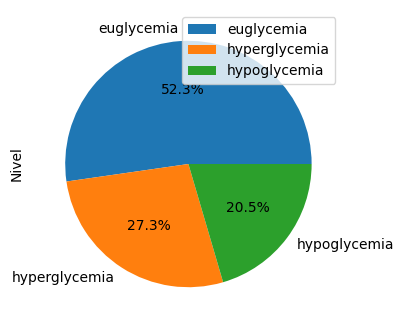

In [144]:
dfResult['Nivel'].value_counts().plot.pie(y='level_label',legend=True,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

In [145]:
dump(eventosP1, open('dataset/generado/paciente1/eventos.list', 'wb'))
print(len(eventosP1))

24


In [146]:
dump(eventosP2, open('dataset/generado/paciente2/eventos.list', 'wb'))
print(len(eventosP2))

24


In [147]:
dump(eventosP3, open('dataset/generado/paciente3/eventos.list', 'wb'))
print(len(eventosP3))

24


In [148]:
dump(eventosP4, open('dataset/generado/paciente4/eventos.list', 'wb'))
print(len(eventosP4))

24


## Guardamos los IDs de los pacientes para modelo general

In [149]:
dfPacienteCount

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
...,...
LIB193282,1808
LIB193366,1287
LIB193398,1253
LIB193283,1098


In [150]:
pacientesEvaluacion=[pq1,pq2,pq3,pq4]
dfPacienteCount=dfPacienteCount[~dfPacienteCount.index.isin(pacientesEvaluacion)]
dfPacienteCount['ID']=dfPacienteCount.index
dfPacienteCount

,Freq,ID
LIB193277,114563,LIB193277
LIB193385,112924,LIB193385
LIB193307,104043,LIB193307
LIB193309,77285,LIB193309
LIB193367,76611,LIB193367
...,...,...
LIB193282,1808,LIB193282
LIB193366,1287,LIB193366
LIB193398,1253,LIB193398
LIB193283,1098,LIB193283


In [151]:
dfPacienteCount['ID'].to_csv('dataset/generado/IDs_ModelGen.csv', index=False) 